In [ ]:
!pip install diffusers
!pip install transformers
!pip install accelerate

In [ ]:
from diffusers import AutoPipelineForInpainting, AutoPipelineForImage2Image
from diffusers.utils import load_image
import torch
import os

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


  0%|          | 0/20 [00:00<?, ?it/s]

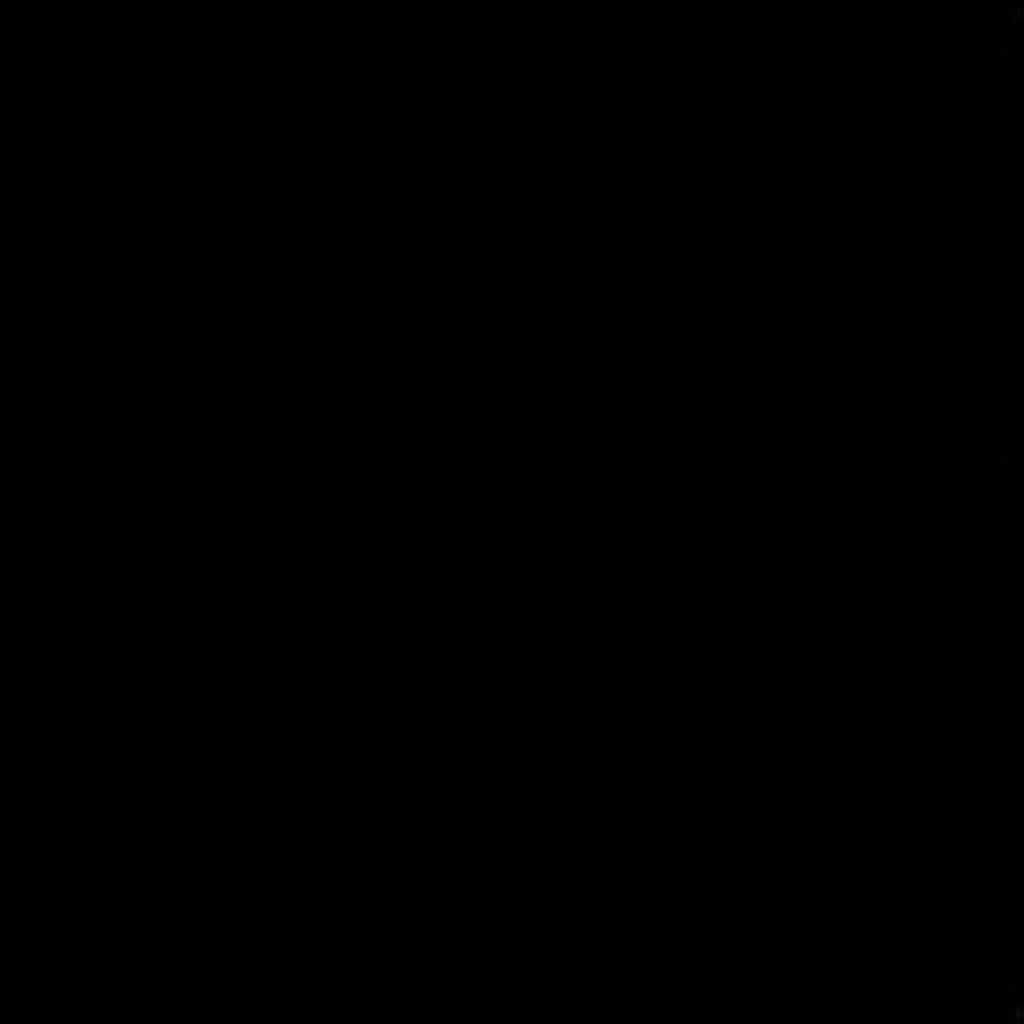

In [10]:
torch.backends.cuda.matmul.allow_tf32 = True
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = AutoPipelineForInpainting.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, variant="fp16", use_safetensors=True) 
pipe = pipe.to(torch_device)
pipe.enable_vae_slicing()
pipe.enable_sequential_cpu_offload()
pipe.enable_model_cpu_offload()

img_url = "rock.png"
mask_url = "rock_mask.png"

image = load_image(img_url)
mask_image = load_image(mask_url)

prompt = "a dlsr photo of the rock"
generator = torch.Generator(device="cuda").manual_seed(0)

image = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=8.0,
    num_inference_steps=20,
    generator=generator,
).images[0]


image = image.resize((768, 512))

pipe = AutoPipelineForInpainting.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True) 
pipe = pipe.to(torch_device)
pipe.enable_vae_slicing()
pipe.enable_sequential_cpu_offload()
pipe.enable_model_cpu_offload()

image = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=8.0,
    num_inference_steps=100,
    strength=0.2,
    generator=generator,
    output_type="latent",  # let's keep in latent to save some VRAM
).images[0]

pipe = AutoPipelineForImage2Image.from_pipe(pipe)
pipe = pipe.to(torch_device)
pipe.enable_vae_slicing()
pipe.enable_sequential_cpu_offload()
pipe.enable_model_cpu_offload()

image = pipe(
    prompt=prompt,
    image=image,
    guidance_scale=8.0,
    num_inference_steps=100,
    strength=0.2,
    generator=generator,
).images[0]
image